In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix
import os
import random
import gc

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)

In [3]:
# Define the Attention Layer
class Attention(nn.Module):
    def __init__(self, shape):
        super(Attention, self).__init__()
        self.attention_dense = nn.Linear(shape, shape)
    
    def forward(self, inputs):
        # Apply linear transformation
        a = self.attention_dense(inputs)
        # Apply softmax to get attention scores
        attention_scores = torch.softmax(a, dim=-1)
        # Element-wise multiplication with inputs
        output_attention_mul = inputs * attention_scores
        return output_attention_mul, attention_scores

# Define the Model
class CustomModel_attext(nn.Module):
    def __init__(self, n_wind, n_features, dense_nparams1=256, n_classes=15):  # n_classes is added
        super(CustomModel_attext, self).__init__()
        self.attention = Attention(n_features)
        self.lstm = nn.LSTM(n_features, dense_nparams1, num_layers=1, batch_first=True)
        self.dense = nn.Linear(dense_nparams1, n_classes)  # Output layer now has n_classes outputs
    
    def forward(self, x, return_attention=False):
        # Get the attended output and attention scores
        x, attention_scores = self.attention(x)
        # Pass through LSTM
        x, _ = self.lstm(x)
        # Extract the last output of the LSTM
        x = x[:, -1, :]
        # Apply the dense layer to get logits (no softmax)
        logits = self.dense(x)
        
        if return_attention:
            return logits, attention_scores
        return logits

## load test data

In [92]:
dtest_all = torch.load('Phenotyping/Ptest.pt')
ytest = torch.load('Phenotyping/y_test.pt')

In [5]:
dtest.shape, ytest.shape

(torch.Size([2217, 288, 231]), torch.Size([2217]))

### find ytest_distribution

In [6]:
ytestnp = ytest.numpy()

In [7]:
text_labels = ['Cardiovascular', 'Respiratory', 'Gastrointestinal', 'Neurological', 'Other Medical Disease', 'Trauma not surgical',
               'Metabolic/Endocrinology', 'Hematologic', 'Cardiovascular Surgical', 'Respiratory Surgical', 'Gastrointestinal Surgical',
               'Neurological Surgical', 'Trauma Surgical', 'Renal Surgical', 'Other Surgical']

In [8]:
# Get the unique labels and their counts
unique_labels, counts = np.unique(ytestnp, return_counts=True)

# If you want the percentage distribution
total = ytestnp.shape[0]


# Display the distribution
for label, count in zip(unique_labels, counts):
    percentage_distribution = (count / total) * 100
    # print(f"Label {label}: {count} occurrences Label {label}: {percentage_distribution:.2f}%")
    print(f"Label {label}: {count} {text_labels[int(label)]} ")


Label 0.0: 355 Cardiovascular 
Label 1.0: 260 Respiratory 
Label 2.0: 130 Gastrointestinal 
Label 3.0: 503 Neurological 
Label 4.0: 121 Other Medical Disease 
Label 5.0: 162 Trauma not surgical 
Label 6.0: 44 Metabolic/Endocrinology 
Label 7.0: 6 Hematologic 
Label 8.0: 297 Cardiovascular Surgical 
Label 9.0: 31 Respiratory Surgical 
Label 10.0: 105 Gastrointestinal Surgical 
Label 11.0: 154 Neurological Surgical 
Label 12.0: 20 Trauma Surgical 
Label 13.0: 2 Renal Surgical 
Label 14.0: 27 Other Surgical 


In [9]:
## cardio Indices
cardio_indices = np.where(ytestnp == 0)[0]
resp_indices = np.where(ytestnp == 1)[0]
gastro_indices = np.where(ytestnp == 2)[0]
neuro_indices = np.where(ytestnp == 3)[0]

In [10]:
cardio_indices.shape, resp_indices.shape, gastro_indices.shape, neuro_indices.shape

((355,), (260,), (130,), (503,))

In [57]:
cardio_indices[:5],resp_indices[:5],gastro_indices[:5], neuro_indices[:5]

(array([ 4,  5,  7, 15, 21]),
 array([23, 24, 36, 38, 40]),
 array([ 34,  47,  72,  96, 100]),
 array([ 1, 17, 18, 20, 26]))

In [13]:
# model = CustomModel(288, 231)
model = CustomModel_attext(288, 231, 15)

## load weights

In [14]:
# model.load_state_dict(torch.load("model_checkpoints/phenotyping/models/bm_bal_acc_seed_000.pth"))
model.load_state_dict(torch.load("model_checkpoints/phenotyping/models/bm_bal_acc_seed_001.pth"))
model.eval()  # Set the model to evaluation mode

CustomModel_attext(
  (attention): Attention(
    (attention_dense): Linear(in_features=231, out_features=231, bias=True)
  )
  (lstm): LSTM(231, 15, batch_first=True)
  (dense): Linear(in_features=15, out_features=15, bias=True)
)

### predict on loaded model

In [21]:
model = model.cuda(0)

In [145]:
# dtest = dtest_all.numpy()[7] ## -- cardio
# dtest = dtest_all.numpy()[36] ## -- resp
# dtest = dtest_all.numpy()[72] ## -- gastro
dtest = dtest_all.numpy()[18] ## -- neuro

## load all models

In [146]:
modeldir = sorted(os.listdir('model_checkpoints/phenotyping/models'))

In [147]:
len(modeldir)

1000

In [148]:
len(modeldir)

1000

In [149]:
dtest.shape

(288, 231)

### how to do this loop

In [150]:
pred_list = []
topall_list = []

for i in tqdm(range(1000)):
    modelfile = modeldir[i]
    model = CustomModel_attext(288,231, 15)
    model.load_state_dict(torch.load(f'model_checkpoints/phenotyping/models/{modelfile}'))
    model.eval()  # Set the model to evaluation mode
    model = model.cuda(0)
    dtest_tensor = torch.tensor(dtest).unsqueeze(0).cuda(0)
    with torch.no_grad():
        pred, attention_scores = model(dtest_tensor, return_attention=True)
        # pred = pred.item()
        probabilities = F.softmax(pred, dim=1).cpu().numpy()  # Convert to numpy array if needed
        pred4_class = np.argmax(probabilities, axis=1)
        probabilities  = probabilities.flatten()[0]
        att_scores = attention_scores.squeeze().detach().cpu().numpy()
        
        
    # print(att_scores.shape)
    flattened = att_scores.flatten()
    ranks = np.argsort(np.argsort(-flattened)) + 1
    att_ranks = ranks.reshape(att_scores.shape)
    topall_list.append(att_ranks)
    
    # fig, ax = plt.subplots(1, 1, figsize=(16, 3))
    # im = plt.imshow(att_scores.T, cmap='Reds', aspect='auto', interpolation='nearest')
    # plt.title(f'Seed {i} | Adverse Outcome tpid 7 | Prob: {round(pred7,4)}')
    # plt.xlabel("Time Points")
    # plt.ylabel("Features")
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # fig.colorbar(im, ax=ax, 
    #              location = 'right',
    #              orientation='vertical',
    #              # fraction=0.9,
    #              # aspect=2,
    #              pad=0.01,
    #              # bbox_to_anchor=(0.1,0,1,1),
    #              shrink=0.3,
    #              # anchor=(0.5, 0.5)
    #             )
    # plt.scatter(top_indices[1], top_indices[0], color='r', marker='.', s=20, label='Top Values',alpha=0.5)
    # ax.legend(bbox_to_anchor=(1.125, 1.02))
    # plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [151]:
len(topall_list)

1000

In [152]:
att_rank_array = np.stack(topall_list)

In [153]:
att_rank_array.shape

(1000, 288, 231)

In [154]:
def plot_heatmap(matrix, title="Heatmap", cmap="viridis", xticks_label="Time", yticks_label="Features"):
    """
    Plots a heatmap of the given matrix with labeled start and end ticks.
    """
    plt.figure(figsize=(6, 4))  # Adjusted figure size for better visibility
    plt.imshow(matrix.T, cmap=cmap, aspect='auto')
    plt.colorbar(label="Rank")
    plt.title(title)
    
    # Set labels for the axes
    plt.xlabel(xticks_label)
    plt.ylabel(yticks_label)
    
    # Add start and end ticks for both axes
    plt.yticks([0, matrix.shape[1] - 1], [0, matrix.shape[1] - 1])  # X-axis (time)
    plt.xticks([0, matrix.shape[0] - 1], [0, matrix.shape[0] - 1])  # Y-axis (features)
    
    plt.show()

In [155]:
def analyze_rank_changes(ranked_matrices):
    """
    Analyzes rank changes across multiple ranked matrices.
    Computes mean and standard deviation of ranks for each entry.
    """
    ranked_matrices = np.stack(ranked_matrices)  # Shape: (num_matrices, rows, cols)
    
    mean_ranks = np.mean(ranked_matrices, axis=0)
    std_ranks = np.std(ranked_matrices, axis=0)
    
    return mean_ranks, std_ranks

In [156]:
# # Step 1: Plot heatmap for the first matrix
# first_matrix = att_rank_array[0]
# plot_heatmap(first_matrix, title="Heatmap of Ranked Values (Matrix 1)")

In [157]:
# # Step 1: Analyze rank changes across all matrices
# mean_ranks, std_ranks = analyze_rank_changes(att_rank_array)

# # Step 2: Plot heatmaps for mean and standard deviation of ranks
# plot_heatmap(mean_ranks, title="Mean Ranks Across Models")
# # plot_heatmap(std_ranks, title="Rank Standard Deviation Across Models", cmap="coolwarm")

In [158]:
ranked_matrices=att_rank_array

In [159]:
rank_variances = np.var(ranked_matrices, axis=0)

In [160]:
np.min(rank_variances), np.max(rank_variances)

(9214186.421596013, 888190849.8871989)

In [161]:
mean_ranks = np.mean(np.stack(ranked_matrices), axis=0)

In [162]:
np.min(mean_ranks), np.max(mean_ranks)

(3166.588, 65908.898)

In [163]:
mean_ranks.shape

(288, 231)

In [164]:
# # Plot the histogram of mean ranks with a logarithmic x-axis
# plt.figure(figsize=(10, 6))
# plt.hist(mean_ranks.flatten(), bins=1000, color='blue', alpha=0.7, edgecolor='black')
# plt.xscale('symlog')  # Set x-axis to logarithmic scale
# # plt.yscale('log')  # Set x-axis to logarithmic scale
# plt.title("Histogram of Mean Ranks Across Models")
# plt.xlabel("Mean Rank (Log Scale)")
# plt.ylabel("Frequency")
# plt.grid(True, which="both", linestyle='--', linewidth=0.5)
# plt.show()

In [165]:
ranked_matrices_sub = ranked_matrices[:100]

In [166]:
# Step 1: Compute cumulative average ranks across models
from matplotlib.colors import LogNorm

cumulative_average_ranks = np.cumsum(ranked_matrices, axis=0) / np.arange(1, ranked_matrices.shape[0] + 1)[:, None, None]

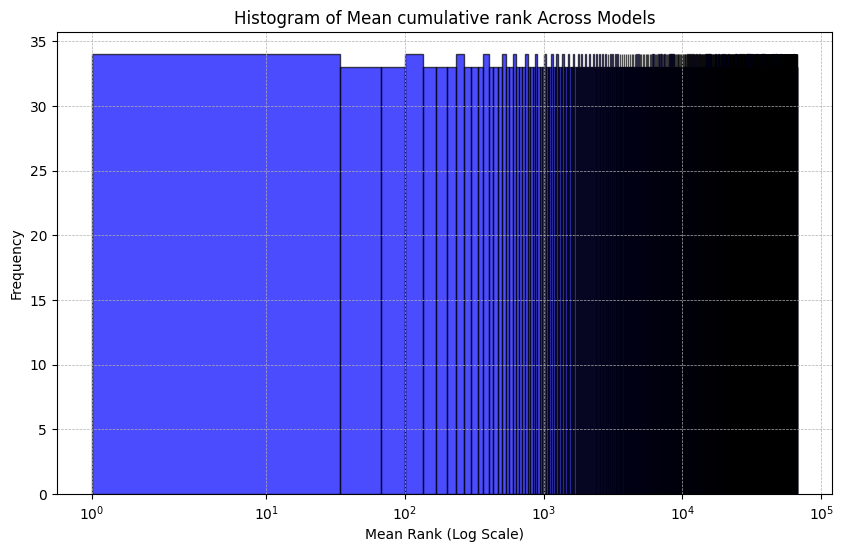

In [167]:
# Plot the histogram of mean ranks with a logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.hist(cumulative_average_ranks[0].flatten(), bins=2000, color='blue', alpha=0.7, edgecolor='black')
# plt.yscale('symlog')  # Set x-axis to logarithmic scale
plt.xscale('symlog')  # Set x-axis to logarithmic scale
plt.title("Histogram of Mean cumulative rank Across Models")
plt.xlabel("Mean Rank (Log Scale)")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

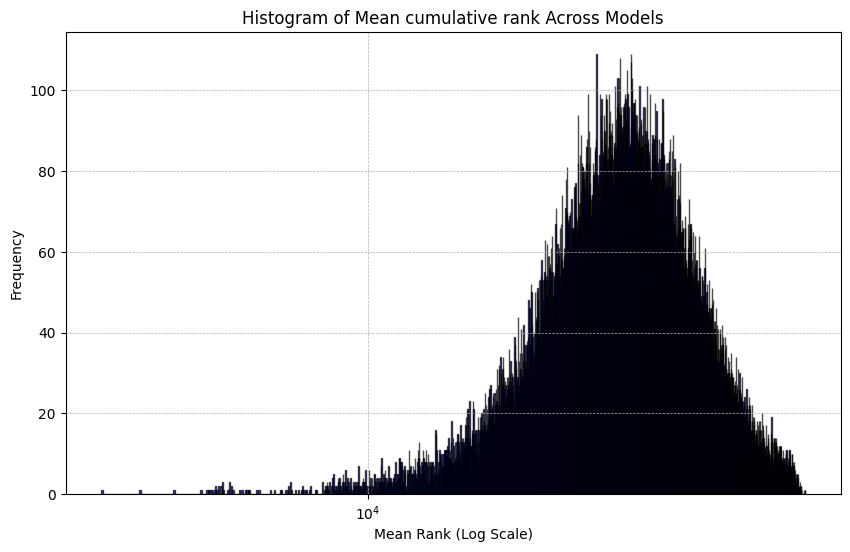

In [168]:
# Plot the histogram of mean ranks with a logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.hist(cumulative_average_ranks[-1].flatten(), bins=2000, color='blue', alpha=0.7, edgecolor='black')
# plt.yscale('symlog')  # Set x-axis to logarithmic scale
plt.xscale('symlog')  # Set x-axis to logarithmic scale
plt.title("Histogram of Mean cumulative rank Across Models")
plt.xlabel("Mean Rank (Log Scale)")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

In [84]:
# indices = [2**i for i in range(5) if 2**i <= 1000]  # Ensure indices are within the range of 1 to 1000

In [169]:
indices = [1, 2, 4, 8, 16, 32]

In [ ]:
# Step 2: Create a 4x4 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(6, 6))
# fig.suptitle("Histogram of Mean Cumulative Ranks Across Models", fontsize=16)

# Step 3: Plot each histogram
for ax, idx in zip(axes.flatten(), indices):
    data = cumulative_average_ranks[idx - 1].flatten()  # Flatten the matrix for the selected model
    ax.hist(data, bins=10000, color='red', alpha=0.7, edgecolor='black',linewidth=0.3)
    ax.set_xscale('symlog')  # Log scale for x-axis
    ax.set_yscale('symlog')  # Log scale for y-axis
    ax.set_title(f"CMV {idx}", fontsize=12)
    ax.set_xlim(1, 66528)  # Set consistent x-axis limits
    ax.set_ylim(0, 40)  # Set consistent y-axis limits
    # ax.set_xlabel("Mean Rank (Log Scale)")
    # ax.set_ylabel("Frequency (Log Scale)")
    ax.set_xlabel("Cumulative Mean Rank")
    ax.set_ylabel("Frequency")
    ax.grid(True, which="both", linestyle='--', linewidth=0.5,alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvline(x=33265, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.text(10000, ax.get_ylim()[1] * 0.9, "33265", color='red', fontsize=10, rotation=0, va='center')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 1])
# plt.show()
plt.savefig('Figure05_neuro_rank_analysis.png', dpi=400, bbox_inches='tight')

In [218]:
running_means = []
running_sum = 0

# Calculate running mean for each value in the values list
for i, value in enumerate(pred_list):
    running_sum += value
    running_mean = running_sum / (i + 1)
    running_means.append(round(running_mean, 4))  # Restrict to 4 decimal places

# Print the results
print("Values:", pred_list)
print("Running Means:", running_means)

Values: [0.9868312, 0.9493867, 0.9872814, 0.9959726, 0.98618037, 0.9627113, 0.9939587, 0.9891248, 0.9924455, 0.9939023]
Running Means: [0.9868, 0.9681, 0.9745, 0.9799, 0.9811, 0.9781, 0.9803, 0.9814, 0.9827, 0.9838]


In [201]:
# top_indices

In [202]:
# top500_list

In [219]:
# # Initialize a 2D matrix with zeros
# matrix = np.zeros((231, 288), dtype=int)

# # Fill the matrix with 1s at the positions specified by the coordinates
# for y, x in zip(top_indices[0], top_indices[1]):
#     matrix[y, x] = 1

# # Display the resulting matrix
# print(matrix.shape)

In [203]:
# # Initialize a 2D matrix with zeros
# matrix_2 = np.zeros((231, 288), dtype=int)

# # Fill the matrix with 1s at the positions specified by the coordinates
# for y, x in zip(top_indices_2[0], top_indices_2[1]):
#     matrix_2[y, x] = 1

# # Display the resulting matrix
# print(matrix_2.shape)

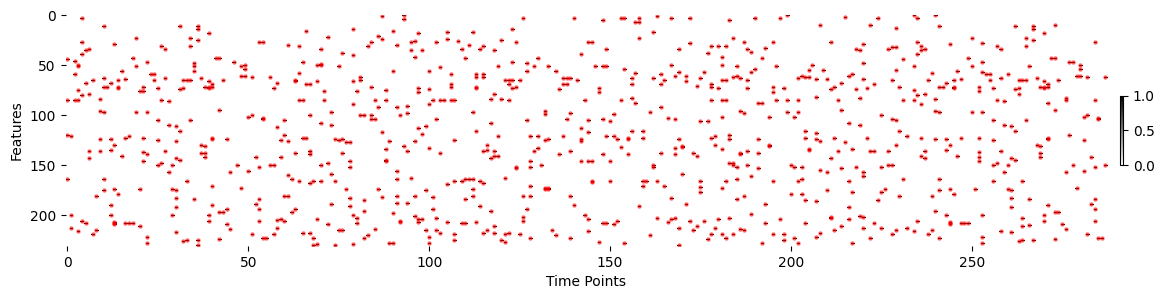

In [220]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))

im = plt.imshow(matrix, cmap='binary', aspect='auto', interpolation='nearest')
# plt.title(f'Seed {i} | Adverse Outcome tpid 7 | Prob: {round(pred7,4)}')
plt.xlabel("Time Points")
plt.ylabel("Features")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
fig.colorbar(im, ax=ax, 
             location = 'right',
             orientation='vertical',
             # fraction=0.9,
             # aspect=2,
             pad=0.01,
             # bbox_to_anchor=(0.1,0,1,1),
             shrink=0.3,
             # anchor=(0.5, 0.5)
            )
plt.scatter(top_indices[1], top_indices[0], color='r', marker='.', s=20, label='Top Values',alpha=0.5)
# ax.legend(bbox_to_anchor=(1.125, 1.02))
plt.show()

In [222]:
# top500_list[0][0] == top500_list[1][0]

## cumulative drop in top features

0 cumulative matrix sum 1000


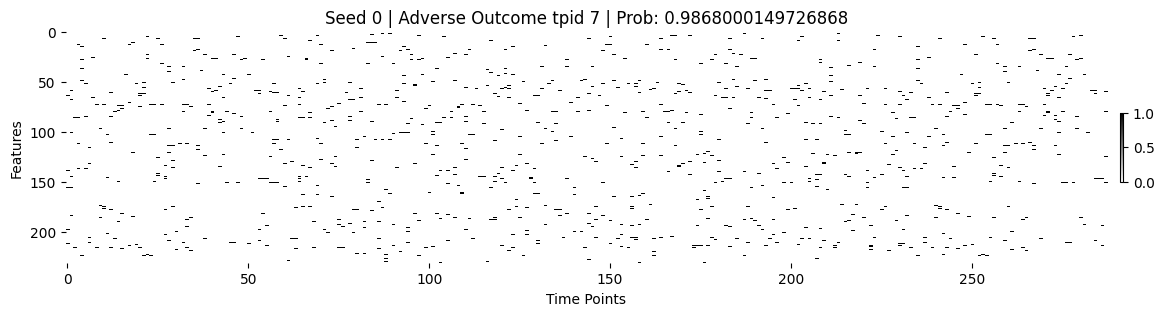

1 cumulative matrix sum 69


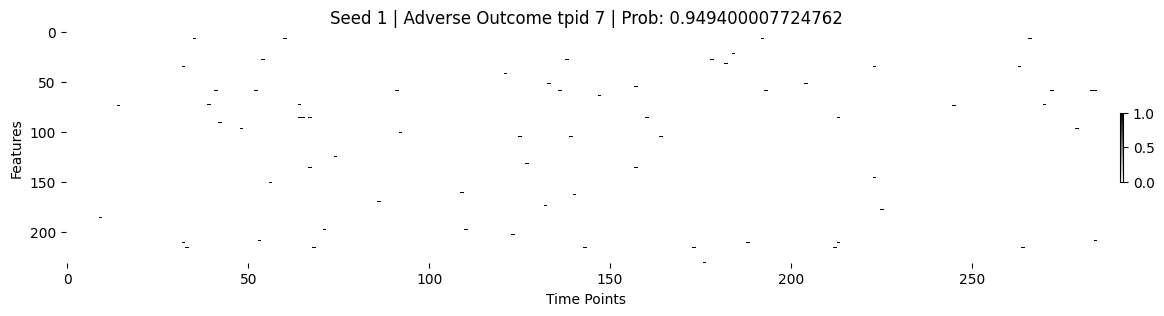

2 cumulative matrix sum 7


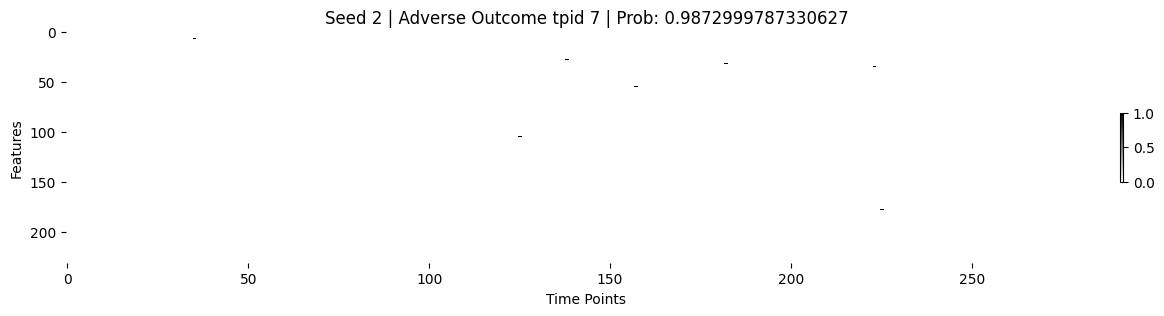

3 cumulative matrix sum 2


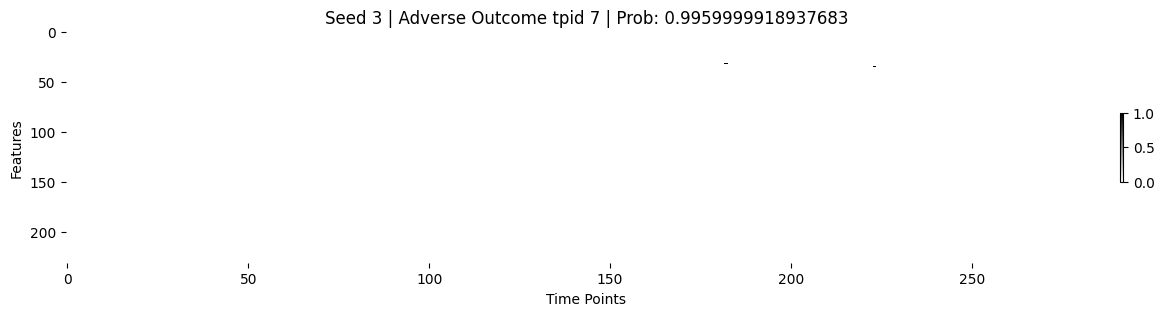

4 cumulative matrix sum 0


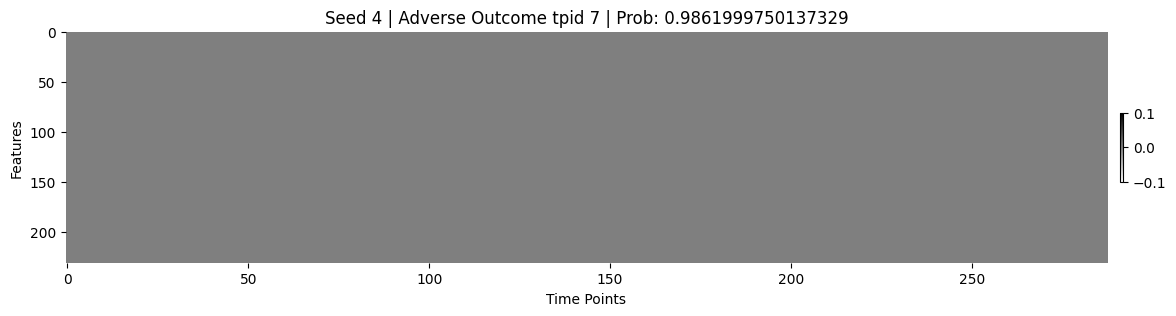

5 cumulative matrix sum 0


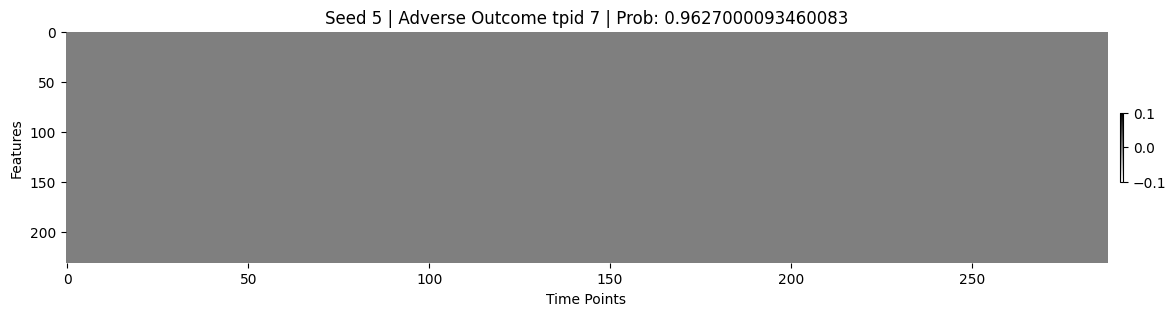

6 cumulative matrix sum 0


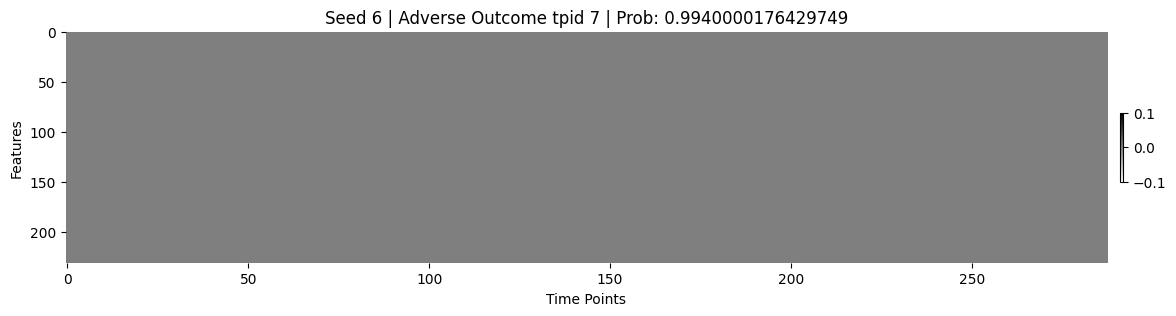

7 cumulative matrix sum 0


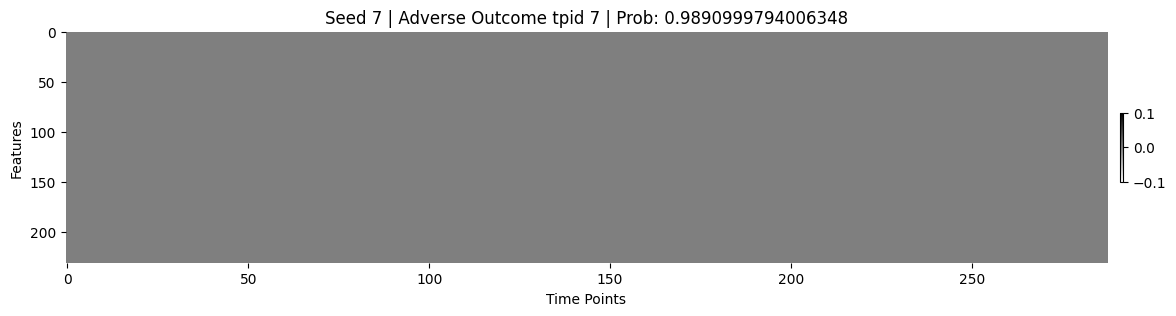

8 cumulative matrix sum 0


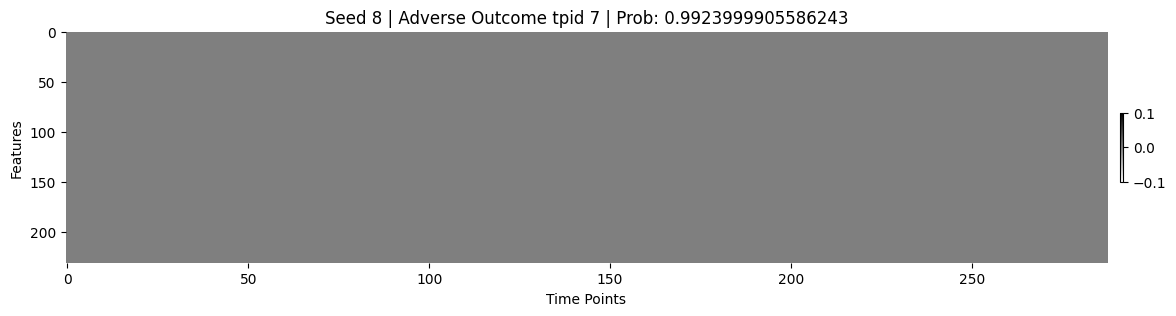

9 cumulative matrix sum 0


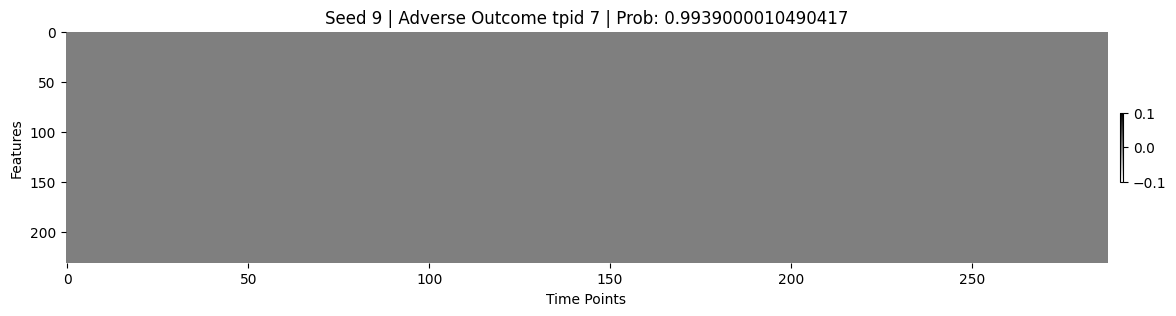

In [223]:
# Initialize a cumulative matrix with ones (will be used for logical AND)
cumulative_matrix = np.ones((231, 288), dtype=int)  # Ensure correct matrix size
cl_list = []
# Iterate through each set of top_indices tuples
for i, top_indices in enumerate(top500_list):
    # Initialize a 2D matrix with zeros for the current run
    matrix = np.zeros((231, 288), dtype=int)  # Ensure correct matrix size
    
    # Fill the matrix with 1s at the positions specified by the coordinates
    for y, x in zip(top_indices[0], top_indices[1]):
        matrix[y, x] = 1
    
    # Print the shape of the matrix for the current run
    # print(f"Run {i+1} - Matrix shape: {matrix.shape}")
    
    # print(f'{i} matrix sum', np.sum(matrix))
    
    # Perform an element-wise logical AND with the cumulative matrix
    cumulative_matrix = np.logical_and(cumulative_matrix, matrix)
    
    print(f'{i} cumulative matrix sum', np.sum(cumulative_matrix))
    
    cl_list.append(np.sum(cumulative_matrix))
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 3))

    im = plt.imshow(cumulative_matrix, cmap='binary', aspect='auto', interpolation='nearest')
    plt.title(f'Seed {i} | Adverse Outcome tpid 7 | Prob: {round(pred_list[i],4)}')
    plt.xlabel("Time Points")
    plt.ylabel("Features")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    fig.colorbar(im, ax=ax, 
                 location = 'right',
                 orientation='vertical',
                 # fraction=0.9,
                 # aspect=2,
                 pad=0.01,
                 # bbox_to_anchor=(0.1,0,1,1),
                 shrink=0.3,
                 # anchor=(0.5, 0.5)
                )
    # plt.scatter(top_indices[1], top_indices[0], color='r', marker='.', s=20, label='Top Values',alpha=0.5)
    # ax.legend(bbox_to_anchor=(1.125, 1.02))
    plt.show()

In [208]:
# cl_list

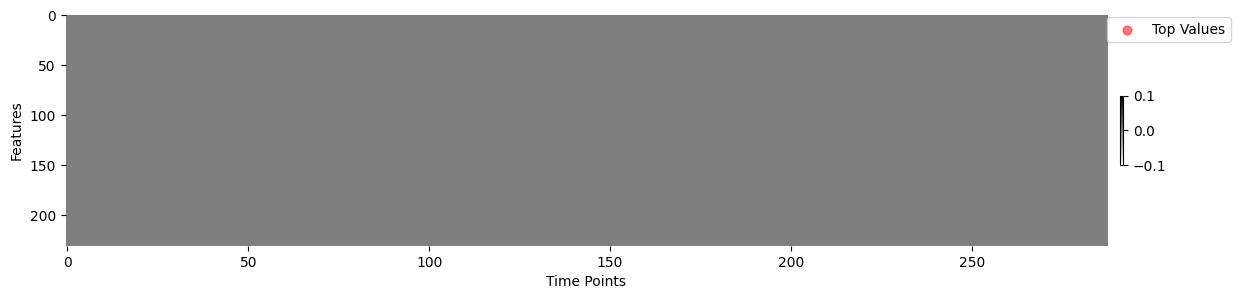

In [224]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))

im = plt.imshow(cumulative_matrix, cmap='binary', aspect='auto', interpolation='nearest')
# plt.title(f'Seed {i} | Adverse Outcome tpid 7 | Prob: {pred_list[i].2f}')
plt.xlabel("Time Points")
plt.ylabel("Features")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
fig.colorbar(im, ax=ax, 
             location = 'right',
             orientation='vertical',
             # fraction=0.9,
             # aspect=2,
             pad=0.01,
             # bbox_to_anchor=(0.1,0,1,1),
             shrink=0.3,
             # anchor=(0.5, 0.5)
            )

## Get the indices where the value in the matrix is 1
y_indices, x_indices = np.where(cumulative_matrix == 1)

# Convert the indices to a tuple
coordinates_tuple = (y_indices.tolist(), x_indices.tolist())

plt.scatter(coordinates_tuple[1], coordinates_tuple[0], color='r', marker='o', s=40, label='Top Values',alpha=0.5)
ax.legend(bbox_to_anchor=(1.125, 1.02))
plt.show()

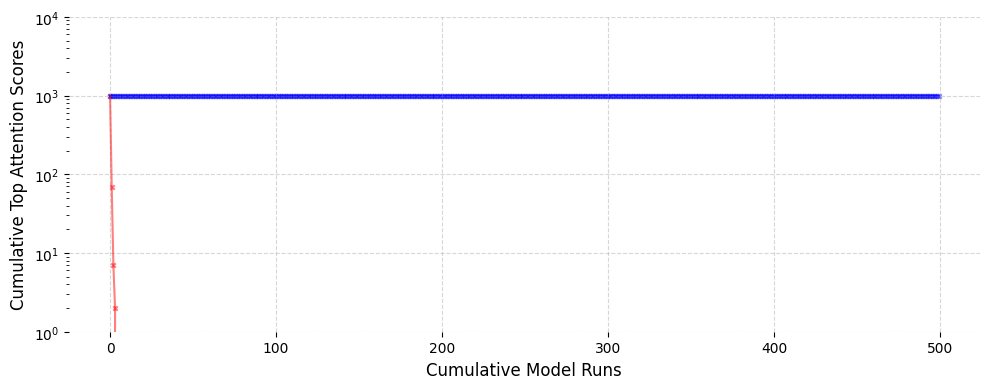

In [225]:
# Example list of 100 numbers (Replace this with your actual list)
numbers1000 = cl_list

# Create a list of indices for the x-axis
indices1000 = list(range(len(numbers1000)))

numbers10000 = cl_list_10000
indices10000 = list(range(len(numbers10000)))

# Create the scatter plot
fig, ax = plt.subplots(1, 1, figsize=(10, 4)) # Set figure size for better clarity

# Scatter plot with custom marker size, edge color, and transparency (alpha)
plt.scatter(indices1000, numbers1000, color='r', marker='x', s=10, alpha=0.5)
plt.plot(indices1000, numbers1000, color='r', alpha=0.5)

# Scatter plot with custom marker size, edge color, and transparency (alpha)
plt.scatter(indices10000, numbers10000, color='b', marker='x', s=10, alpha=0.5)
plt.plot(indices10000, numbers10000, color='b', alpha=0.5)

# Add a color bar to give context to the color mapping
# plt.colorbar(label='Value Intensity')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add labels and title with enhanced font size
plt.xlabel('Cumulative Model Runs', fontsize=12)
plt.ylabel('Cumulative Top Attention Scores', fontsize=12)
# plt.title('Scatter Plot of List Values', fontsize=15, weight='bold')

# Enhance ticks for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.yscale('log')
plt.ylim(1,10001)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Display the plot
plt.tight_layout()  # Adjust layout to make sure everything fits nicely
plt.show()

In [102]:
# invert_cm = ~cumulative_matrix
# invert_bin= invert_cm.astype(int).T

In [103]:
# invert_bin.shape

In [104]:
# np.sum(invert_bin), np.sum(cumulative_matrix), 288*231

In [105]:
# xperm = invert_bin*dtest7
# xperm = xperm.astype(np.float32)

In [106]:
# dtest7.dtype, xperm.dtype

### now the top 30 are 0, when 1000 top scores were selected

In [107]:
# dtest7_pert = xperm

In [226]:
# pred_list = []
# top500_list = []

# for i in tqdm(range(100)):
#     modelfile = modeldir[i]
#     model = CustomModel_attext(288,231, 15)
#     model.load_state_dict(torch.load(f'model_checkpoints/phenotyping/models/{modelfile}'))
#     model.eval()  # Set the model to evaluation mode
#     model = model.cuda(0)
#     pred7_pert = model(torch.tensor(dtest7_pert).unsqueeze(0).cuda(0)).item()
    
#     pred_list.append(round(pred7_pert,4))

#     # Extract the weight matrix from the attention_dense layer
#     weight_matrix = model.attention.attention_dense.weight.data
#     wmnp = weight_matrix.detach().cpu().numpy()
    
#     input_after_att = np.dot(dtest7,wmnp)
#     att_scores = F.softmax(torch.tensor(input_after_att), dim=1)
    
#     # Define the number of top values to highlight
#     num_top_values = 1000 #500

#     # Find the indices of the top N values
#     flat_indices = np.argsort(att_scores.T, axis=None)[-num_top_values:]
#     top_indices = np.unravel_index(flat_indices, att_scores.T.shape)
    
#     top500_list.append(top_indices)

In [91]:
# running_means = []
# running_sum = 0

# # Calculate running mean for each value in the values list
# for i, value in enumerate(pred_list):
#     running_sum += value
#     running_mean = running_sum / (i + 1)
#     running_means.append(round(running_mean, 4))  # Restrict to 4 decimal places

# # Print the results
# print("Values:", pred_list)
# print("Running Means:", running_means)

In [94]:
# # Initialize a cumulative matrix with ones (will be used for logical AND)
# cumulative_matrix = np.ones((231, 288), dtype=int)  # Ensure correct matrix size
# cl_list = []
# # Iterate through each set of top_indices tuples (10 runs)
# for i, top_indices in enumerate(top500_list):
#     # Initialize a 2D matrix with zeros for the current run
#     matrix = np.zeros((231, 288), dtype=int)  # Ensure correct matrix size
    
#     # Fill the matrix with 1s at the positions specified by the coordinates
#     for y, x in zip(top_indices[0], top_indices[1]):
#         matrix[y, x] = 1
    
#     # Print the shape of the matrix for the current run
#     # print(f"Run {i+1} - Matrix shape: {matrix.shape}")
    
#     # print(f'{i} matrix sum', np.sum(matrix))
    
#     # Perform an element-wise logical AND with the cumulative matrix
#     cumulative_matrix = np.logical_and(cumulative_matrix, matrix)
    
#     # print(f'{i} cumulative matrix sum', np.sum(cumulative_matrix))
    
#     cl_list.append(np.sum(cumulative_matrix))

In [93]:
# # Example list of 100 numbers (Replace this with your actual list)
# numbers = cl_list  # Generate 100 random numbers for demonstration

# # Create a list of indices for the x-axis
# indices = list(range(len(numbers)))

# # Create the scatter plot
# plt.figure(figsize=(10, 4))  # Set figure size for better clarity

# # Scatter plot with custom marker size, edge color, and transparency (alpha)
# plt.scatter(indices, numbers, color='r', marker='o', edgecolor='k', s=10, alpha=0.8)

# # Add a color bar to give context to the color mapping
# plt.colorbar(label='Value Intensity')

# # Add grid for better readability
# plt.grid(True, linestyle='--', alpha=0.5)

# # Add labels and title with enhanced font size
# plt.xlabel('Cumulative Model Runs', fontsize=12)
# plt.ylabel('Cumulative Top Attention Scores', fontsize=12)
# # plt.title('Scatter Plot of List Values', fontsize=15, weight='bold')

# # Enhance ticks for better readability
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)

# # Display the plot
# plt.tight_layout()  # Adjust layout to make sure everything fits nicely
# plt.show()

In [121]:
# cl_list

In [108]:
# model

In [109]:
# pred7 = model(torch.tensor(dtest7).unsqueeze(0).cuda(0)).item()

In [110]:
# pred7

In [111]:
# weight_matrix = model.attention.attention_dense.weight.data
# wmnp = weight_matrix.detach().cpu().numpy()

In [112]:
## check about it
# model.attention.attention_dense.bias.shape

In [113]:
# plt.figure(figsize=(8, 8))
# sns.heatmap(wmnp, annot=False, cmap='coolwarm', cbar=True, square=True)
# plt.title('Attention Weights')
# plt.xlabel("Features")
# plt.ylabel("Features")
# plt.show()

In [114]:
# # Step 2: Flatten the weight matrix, shuffle it, and reshape it back
# flattened_weights = weight_matrix.flatten()  # Flatten to 1D array
# shuffled_weights = flattened_weights.clone()  # Create a clone to shuffle
# indices = torch.randperm(shuffled_weights.size(0))  # Generate random permutation of indices
# shuffled_weights = shuffled_weights[indices]  # Apply shuffle
# reshaped_weights = shuffled_weights.view(weight_matrix.shape)  # Reshape back to original shape

In [115]:
# reshaped_weights.shape

In [116]:
# wmnp_shuffled = reshaped_weights.detach().cpu().numpy()

In [117]:
# plt.figure(figsize=(8, 8))
# sns.heatmap(wmnp_shuffled, annot=False, cmap='coolwarm', cbar=True, square=True)
# plt.title('Attention Weights')
# plt.xlabel("Features")
# plt.ylabel("Features")
# plt.show()

In [118]:
# # Step 3: Reassign the shuffled weights back to the model
# model.attention.attention_dense.weight.data = reshaped_weights

In [119]:
# pred7 = model(torch.tensor(dtest7).unsqueeze(0).cuda(0)).item()

In [120]:
# pred7

### one function to rule them all

In [228]:
# modeldir

In [288]:
def cudrop(num_model, topk, pid):

    pred_list = []
    topk_list = []
    
    indices = list(range(num_model))

    # Shuffle the list in place
    random.shuffle(indices)
    
    for i in indices:
        modelfile = modeldir[i]
        model = CustomModel_attext(288,231,15)
        model.load_state_dict(torch.load(f'model_checkpoints/phenotyping/models/{modelfile}'))
        model.eval()  # Set the model to evaluation mode
        model = model.cuda(0)
        dtestp = dtest.numpy()[pid]
        dtestp_tensor = torch.tensor(dtestp).unsqueeze(0).cuda(0)
        with torch.no_grad():
            predp, attention_scores = model(dtestp_tensor, return_attention=True)
            probabilities = F.softmax(predp, dim=1).cpu().numpy()  # Convert to numpy array if needed
            predp_class = np.argmax(probabilities, axis=1)  # Convert to numpy array if needed
            probabilities  = probabilities.flatten()[0]
            att_scores = attention_scores.squeeze().detach().cpu().numpy()

        pred_list.append(round(probabilities,4))

        # Define the number of top values to highlight
        num_top_values = topk #500

        # Find the indices of the top N values
        flat_indices = np.argsort(att_scores.T, axis=None)[-num_top_values:]
        top_indices = np.unravel_index(flat_indices, att_scores.T.shape)

        topk_list.append(top_indices)
        
        
    running_means = []
    running_sum = 0

    # Calculate running mean for each value in the values list
    for i, value in enumerate(pred_list):
        running_sum += value
        running_mean = running_sum / (i + 1)
        running_means.append(round(running_mean, 4))  # Restrict to 4 decimal places
        
        
    cumulative_matrix = np.ones((231, 288), dtype=int)  # Ensure correct matrix size
    cl_list = []
    # Iterate through each set of top_indices tuples (10 runs)
    for i, top_indices in enumerate(topk_list):
        # Initialize a 2D matrix with zeros for the current run
        matrix = np.zeros((231, 288), dtype=int)  # Ensure correct matrix size

        # Fill the matrix with 1s at the positions specified by the coordinates
        for y, x in zip(top_indices[0], top_indices[1]):
            matrix[y, x] = 1

        # Perform an element-wise logical AND with the cumulative matrix
        cumulative_matrix = np.logical_and(cumulative_matrix, matrix)

        cl_list.append(np.sum(cumulative_matrix))
        
        
    return cl_list, list(range(len(cl_list))), pred_list, running_means

In [232]:
# temp = cudrop(20, 100, 5)
# m200_f1000_p24 = cudrop(200, 1000, 24)
# m200_f100_p7 = cudrop(200, 100, 7)

In [233]:
# temp

In [289]:
m100_f10000_p7 = cudrop(100, 10000, 7)
m200_f10000_p7 = cudrop(200, 10000, 7)
m300_f10000_p7 = cudrop(300, 10000, 7)
m400_f10000_p7 = cudrop(400, 10000, 7)
m500_f10000_p7 = cudrop(500, 10000, 7)
m1000_f10000_p7 = cudrop(1000, 10000, 7)

In [290]:
m100_f5000_p7 = cudrop(100, 5000, 7)
m200_f5000_p7 = cudrop(200, 5000, 7)
m300_f5000_p7 = cudrop(300, 5000, 7)
m400_f5000_p7 = cudrop(400, 5000, 7)
m500_f5000_p7 = cudrop(500, 5000, 7)
m1000_f5000_p7 = cudrop(1000, 5000, 7)

In [291]:
m100_f1000_p7 = cudrop(100, 1000, 7)
m200_f1000_p7 = cudrop(200, 1000, 7)
m300_f1000_p7 = cudrop(300, 1000, 7)
m400_f1000_p7 = cudrop(400, 1000, 7)
m500_f1000_p7 = cudrop(500, 1000, 7)
m1000_f1000_p7 = cudrop(1000, 1000, 7)

In [292]:
m100_f100_p7 = cudrop(100, 100, 7)
m200_f100_p7 = cudrop(200, 100, 7)
m300_f100_p7 = cudrop(300, 100, 7)
m400_f100_p7 = cudrop(400, 100, 7)
m500_f100_p7 = cudrop(500, 100, 7)
m1000_f100_p7 = cudrop(1000, 100, 7)

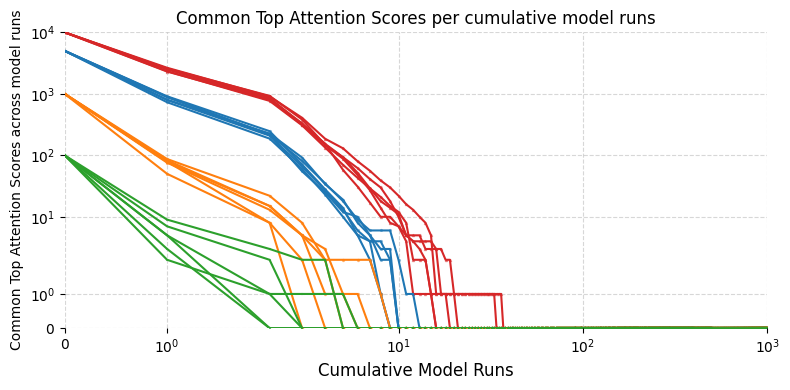

In [293]:
# Create the scatter plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4)) # Set figure size for better clarity
###################################################################################################### for 10000 top features

plt.scatter(m100_f10000_p7[1], m100_f10000_p7[0], color='#d62728', marker='^', s=2, alpha=0.5)
plt.scatter(m200_f10000_p7[1], m200_f10000_p7[0], color='#d62728', marker='^', s=2, alpha=0.5)
plt.scatter(m300_f10000_p7[1], m300_f10000_p7[0], color='#d62728', marker='^', s=2, alpha=0.5)
plt.scatter(m400_f10000_p7[1], m400_f10000_p7[0], color='#d62728', marker='^', s=2, alpha=0.5)
plt.scatter(m500_f10000_p7[1], m500_f10000_p7[0], color='#d62728', marker='^', s=2, alpha=0.5)
plt.scatter(m1000_f10000_p7[1], m1000_f10000_p7[0], color='#d62728', marker='^', s=2, alpha=0.5)

plt.plot(m100_f10000_p7[1], m100_f10000_p7[0], color='#d62728')
plt.plot(m200_f10000_p7[1], m200_f10000_p7[0], color='#d62728')
plt.plot(m300_f10000_p7[1], m300_f10000_p7[0], color='#d62728')
plt.plot(m400_f10000_p7[1], m400_f10000_p7[0], color='#d62728')
plt.plot(m500_f10000_p7[1], m500_f10000_p7[0], color='#d62728')
plt.plot(m1000_f10000_p7[1], m1000_f10000_p7[0], color='#d62728')

###################################################################################################### for 5000 top features

plt.scatter(m100_f5000_p7[1], m100_f5000_p7[0], color='#1f77b4', marker='*', s=2, alpha=0.5)
plt.scatter(m200_f5000_p7[1], m200_f5000_p7[0], color='#1f77b4', marker='*', s=2, alpha=0.5)
plt.scatter(m300_f5000_p7[1], m300_f5000_p7[0], color='#1f77b4', marker='*', s=2, alpha=0.5)
plt.scatter(m400_f5000_p7[1], m400_f5000_p7[0], color='#1f77b4', marker='*', s=2, alpha=0.5)
plt.scatter(m500_f5000_p7[1], m500_f5000_p7[0], color='#1f77b4', marker='*', s=2, alpha=0.5)
plt.scatter(m1000_f5000_p7[1], m1000_f5000_p7[0], color='#1f77b4', marker='*', s=2, alpha=0.5)

plt.plot(m100_f5000_p7[1], m100_f5000_p7[0], color='#1f77b4')
plt.plot(m200_f5000_p7[1], m200_f5000_p7[0], color='#1f77b4')
plt.plot(m300_f5000_p7[1], m300_f5000_p7[0], color='#1f77b4')
plt.plot(m400_f5000_p7[1], m400_f5000_p7[0], color='#1f77b4')
plt.plot(m500_f5000_p7[1], m500_f5000_p7[0], color='#1f77b4')
plt.plot(m1000_f5000_p7[1], m1000_f5000_p7[0], color='#1f77b4')


###################################################################################################### for 1000 top features

plt.scatter(m100_f1000_p7[1], m100_f1000_p7[0], color='#ff7f0e', marker='o', s=2, alpha=0.5)
plt.scatter(m200_f1000_p7[1], m200_f1000_p7[0], color='#ff7f0e', marker='o', s=2, alpha=0.5)
plt.scatter(m300_f1000_p7[1], m300_f1000_p7[0], color='#ff7f0e', marker='o', s=2, alpha=0.5)
plt.scatter(m400_f1000_p7[1], m400_f1000_p7[0], color='#ff7f0e', marker='o', s=2, alpha=0.5)
plt.scatter(m500_f1000_p7[1], m500_f1000_p7[0], color='#ff7f0e', marker='o', s=2, alpha=0.5)
plt.scatter(m1000_f1000_p7[1], m1000_f1000_p7[0], color='#ff7f0e', marker='o', s=2, alpha=0.5)

plt.plot(m100_f1000_p7[1], m100_f1000_p7[0], color='#ff7f0e')
plt.plot(m200_f1000_p7[1], m200_f1000_p7[0], color='#ff7f0e')
plt.plot(m300_f1000_p7[1], m300_f1000_p7[0], color='#ff7f0e')
plt.plot(m400_f1000_p7[1], m400_f1000_p7[0], color='#ff7f0e')
plt.plot(m500_f1000_p7[1], m500_f1000_p7[0], color='#ff7f0e')
plt.plot(m1000_f1000_p7[1], m1000_f1000_p7[0], color='#ff7f0e')

###################################################################################################### for 100 top features

plt.scatter(m100_f100_p7[1], m100_f100_p7[0], color='#2ca02c', marker='+', s=2, alpha=0.5)
plt.scatter(m200_f100_p7[1], m200_f100_p7[0], color='#2ca02c', marker='+', s=2, alpha=0.5)
plt.scatter(m300_f100_p7[1], m300_f100_p7[0], color='#2ca02c', marker='+', s=2, alpha=0.5)
plt.scatter(m400_f100_p7[1], m400_f100_p7[0], color='#2ca02c', marker='+', s=2, alpha=0.5)
plt.scatter(m500_f100_p7[1], m500_f100_p7[0], color='#2ca02c', marker='+', s=2, alpha=0.5)
plt.scatter(m1000_f100_p7[1], m1000_f100_p7[0], color='#2ca02c', marker='+', s=2, alpha=0.5)

plt.plot(m100_f100_p7[1], m100_f100_p7[0], color='#2ca02c')
plt.plot(m200_f100_p7[1], m200_f100_p7[0], color='#2ca02c')
plt.plot(m300_f100_p7[1], m300_f100_p7[0], color='#2ca02c')
plt.plot(m400_f100_p7[1], m400_f100_p7[0], color='#2ca02c')
plt.plot(m500_f100_p7[1], m500_f100_p7[0], color='#2ca02c')
plt.plot(m1000_f100_p7[1], m1000_f100_p7[0], color='#2ca02c')

############################################################################################### 


# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add labels and title with enhanced font size
plt.xlabel('Cumulative Model Runs', fontsize=12)
plt.ylabel('Common Top Attention Scores across model runs', fontsize=10)
plt.title('Common Top Attention Scores per cumulative model runs', fontsize=12, 
          # weight='bold'
         )

# Enhance ticks for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.yscale('symlog')
plt.xscale('symlog')
plt.ylim(0,10000)
plt.xlim(0,1000)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Display the plot
plt.tight_layout()  # Adjust layout to make sure everything fits nicely
plt.show()

## correct color below

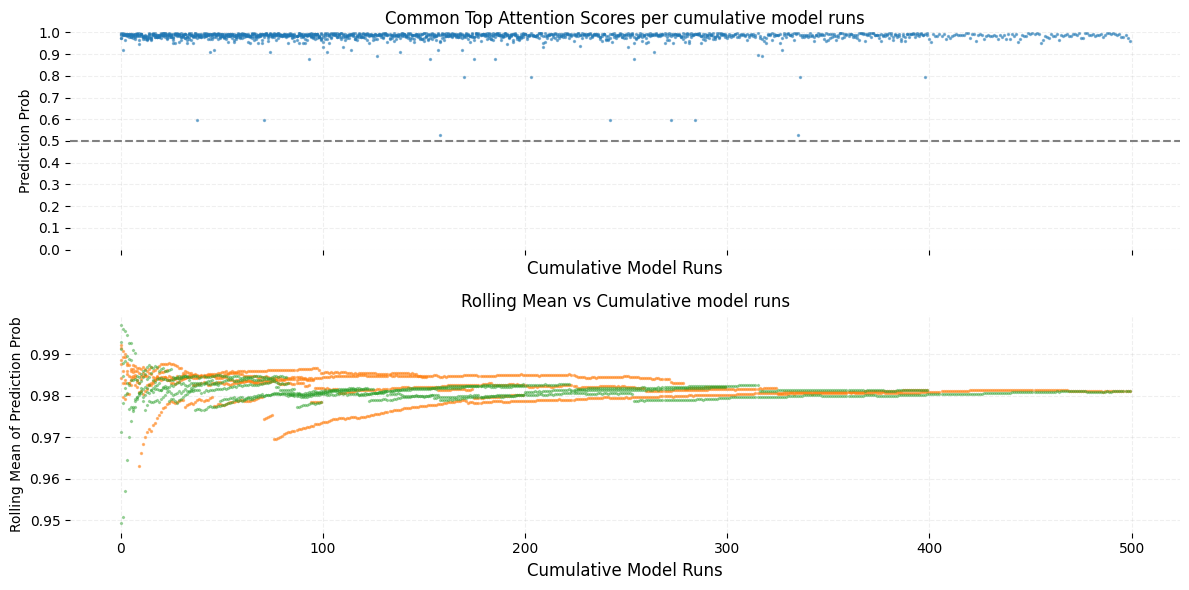

In [294]:
# Create the scatter plot
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)  
###################################################################################################### for 10000 top features
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[0].scatter(m100_f10000_p7[1], m100_f10000_p7[2], color='#1f77b4', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[0].scatter(m200_f10000_p7[1], m200_f10000_p7[2], color='#1f77b4', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[0].scatter(m300_f10000_p7[1], m300_f10000_p7[2], color='#1f77b4', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[0].scatter(m400_f10000_p7[1], m400_f10000_p7[2], color='#1f77b4', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[0].scatter(m500_f10000_p7[1], m500_f10000_p7[2], color='#1f77b4', marker='o', s=2, alpha=0.5)


ax[0].axhline(y=0.5, color='gray', linestyle='--')
## Running Mean of prob
###################################################################################################### for 1000 top features
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m100_f1000_p7[1], m100_f1000_p7[3], color='#ff7f0e', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m200_f1000_p7[1], m200_f1000_p7[3], color='#ff7f0e', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m300_f1000_p7[1], m300_f1000_p7[3], color='#ff7f0e', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m400_f1000_p7[1], m400_f1000_p7[3], color='#ff7f0e', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m500_f1000_p7[1], m500_f1000_p7[3], color='#ff7f0e', marker='o', s=2, alpha=0.5)


###################################################################################################### for 100 top features
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m100_f100_p7[1], m100_f100_p7[3], color='#2ca02c', marker='x', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m200_f100_p7[1], m200_f100_p7[3], color='#2ca02c', marker='x', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m300_f100_p7[1], m300_f100_p7[3], color='#2ca02c', marker='x', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m400_f100_p7[1], m400_f100_p7[3], color='#2ca02c', marker='x', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m500_f100_p7[1], m500_f100_p7[3], color='#2ca02c', marker='x', s=2, alpha=0.5)


# Add grid for better readability
ax[0].grid(True, linestyle='--', alpha=0.2)

# Add labels and title with enhanced font size
ax[0].set_xlabel('Cumulative Model Runs', fontsize=12)
ax[0].set_ylabel('Prediction Prob', fontsize=10)
ax[0].set_title('Common Top Attention Scores per cumulative model runs', fontsize=12, 
          # weight='bold'
         )
# plt.yscale('log')
ax[0].set_ylim(0,1)
yticks = np.arange(0, 1.1, 0.1)  # Generate values from 0 to 1 with a step of 0.1
ax[0].set_yticks(yticks)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
################################################# rolling mean
ax[1].set_xlabel('Cumulative Model Runs', fontsize=12)
ax[1].set_ylabel('Rolling Mean of Prediction Prob', fontsize=10)
ax[1].set_title('Rolling Mean vs Cumulative model runs', fontsize=12, 
          # weight='bold'
         )
ax[1].grid(True, linestyle='--', alpha=0.2)
# ax[1].set_ylim(0.6,0.72)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

# Display the plot
plt.tight_layout()  # Adjust layout to make sure everything fits nicely
plt.show()

# for all patients

In [295]:
import pickle

In [313]:
# adverse_list = cardio_indices.tolist()
# adverse_list = resp_indices.tolist()
adverse_list = gastro_indices.tolist()
# adverse_list = neuro_indices.tolist()

In [314]:
list100  = []
list1000 = []
list10000= []

for i in tqdm(adverse_list):
    list100.append(cudrop(1000, 100, i))
    list1000.append(cudrop(1000, 1000, i))
    list10000.append(cudrop(1000, 10000, i))

  0%|          | 0/130 [00:00<?, ?it/s]

In [298]:
import pickle

In [299]:
# # List comprehension to separate even and odd index elements
# list1k_temp = [list1000[i] for i in range(len(list1000)) if i % 2 == 0]  # Elements at even indices
# list10k_temp = [list1000[i] for i in range(len(list1000)) if i % 2 != 0]   # Elements at odd indices

In [315]:
list1k = list1000
list10k = list10000

In [316]:
len(list100), len(list1k), len(list10k)

(130, 130, 130)

In [317]:
# Save the list to a pickle file
with open('pheno_gastro_cudrop_1000m_100f.pkl', 'wb') as file:  # Open file in binary write mode
    pickle.dump(list100, file)
    
# Save the list to a pickle file
with open('pheno_gastro_cudrop_1000m_1000f.pkl', 'wb') as file:  # Open file in binary write mode
    pickle.dump(list1k, file)
    
# Save the list to a pickle file
with open('pheno_gastro_cudrop_1000m_10000f.pkl', 'wb') as file:  # Open file in binary write mode
    pickle.dump(list10k, file)

In [318]:
list100_mean     = np.mean(np.array([item[0] for item  in list100]),axis=0).tolist()
list1k_mean      = np.mean(np.array([item[0] for item  in list1k]),axis=0).tolist()
list10k_mean     = np.mean(np.array([item[0] for item  in list10k]),axis=0).tolist()

In [319]:
len(list100_mean), len(list1k_mean), len(list10k_mean)

(1000, 1000, 1000)

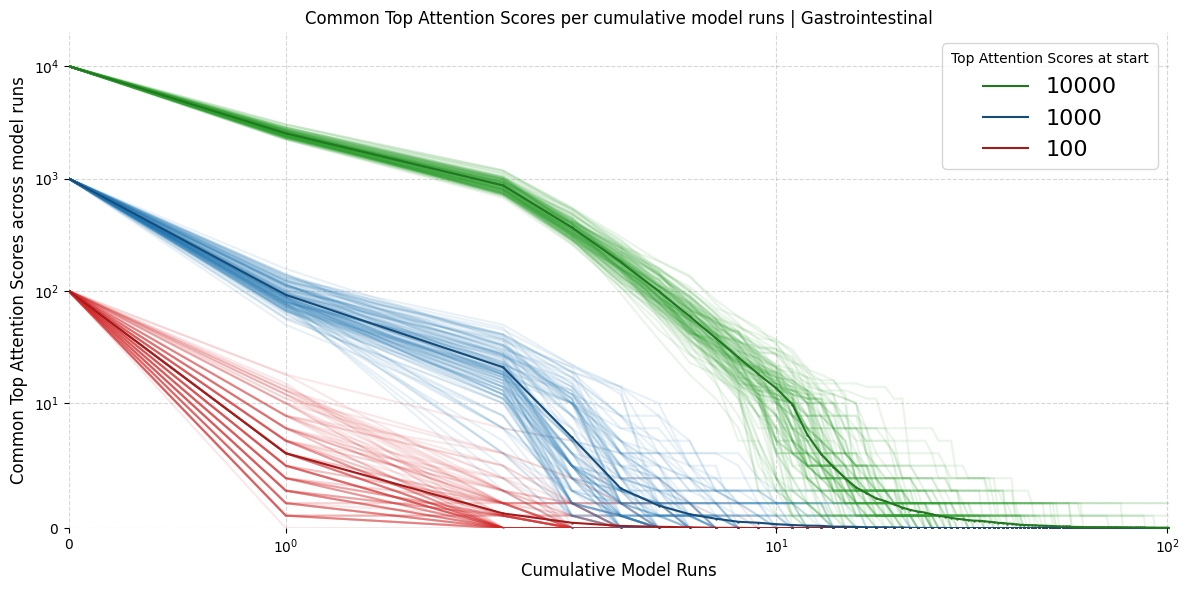

In [323]:
# Create the scatter plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6)) # Set figure size for better clarity
###################################################################################################### for 10000 top features


for item in list100:
    plt.scatter(item[1], item[0], color='#d62728', marker='o', s=1, alpha=0.005)
    plt.plot(item[1], item[0], color='#d62728',alpha=0.1)
    

for item in list1k:
    plt.scatter(item[1], item[0], color='#1f77b4', marker='o', s=1, alpha=0.005)
    plt.plot(item[1], item[0], color='#1f77b4',alpha=0.1)
    
    
for item in list10k:
    plt.scatter(item[1], item[0], color='#2ca02c', marker='o', s=1, alpha=0.005)
    plt.plot(item[1], item[0], color='#2ca02c',alpha=0.1)    

############################################################################################### 

plt.scatter(list(range(len(list100_mean))), list100_mean, color='#a31c1c', marker='.', s=2, alpha=1.0)
plt.plot(list(range(len(list100_mean))), list100_mean, color='#a31c1c',alpha=1.0, label='100')

plt.scatter(list(range(len(list1k_mean))), list1k_mean, color='#154c7a', marker='.', s=2, alpha=1.0)
plt.plot(list(range(len(list1k_mean))), list1k_mean, color='#154c7a',alpha=1.0, label='1000')

plt.scatter(list(range(len(list10k_mean))), list10k_mean, color='#217821', marker='.', s=2, alpha=1.0)
plt.plot( list(range(len(list10k_mean))), list10k_mean, color='#217821',alpha=1.0,label='10000')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add labels and title with enhanced font size
plt.xlabel('Cumulative Model Runs', fontsize=12)
plt.ylabel('Common Top Attention Scores across model runs', fontsize=12)
plt.title('Common Top Attention Scores per cumulative model runs | Gastrointestinal', fontsize=12, 
          # weight='bold'
         )

# Enhance ticks for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.yscale('symlog', 
           linthresh=10
          )
# plt.yscale('asinh', linthresh=10)
plt.xscale('symlog', 
           # linthresh=10
          )
# plt.xscale('asinh')

plt.ylim(0,20000)
plt.xlim(0,101)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Display the plot
# Reversing the order of the legend items
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper right', fontsize=16, title='Top Attention Scores at start')  # Reversing handles and labels

plt.tight_layout()  # Adjust layout to make sure everything fits nicely
plt.show()

In [521]:
### scatter for probabiility -- this doesn't work

In [516]:
# # Create the scatter plot
# fig, ax = plt.subplots(1, 1, figsize=(12, 6)) # Set figure size for better clarity
# ###################################################################################################### for 10000 top features


# # for item in list100:
# #     plt.scatter(item[1], item[2], color='#d62728', marker='o', s=1, alpha=0.1)
# #     # plt.plot(item[1], item[2], color='#d62728',alpha=0.1)
    

# # for item in list1k:
# #     plt.scatter(item[1], item[2], color='#1f77b4', marker='o', s=1, alpha=0.1)
# #     # plt.plot(item[1], item[2], color='#1f77b4',alpha=0.1)
    
    
# for item in list10k:
#     plt.scatter(item[1], item[3], color='#ff7f0e', marker='o', s=1, alpha=0.1)
#     # plt.plot(item[1], item[2], color='#ff7f0e',alpha=0.1)    

# ############################################################################################### 

# # Add grid for better readability
# plt.grid(True, linestyle='--', alpha=0.5)

# # Add labels and title with enhanced font size
# plt.xlabel('Cumulative Model Runs', fontsize=12)
# plt.ylabel('Common Top Attention Scores across model runs', fontsize=16)
# plt.title('Common Top Attention Scores per cumulative model runs', fontsize=12, 
#           # weight='bold'
#          )

# # Enhance ticks for better readability
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# # plt.yscale('symlog')
# # plt.xscale('log')
# # plt.ylim(0,10000)
# # plt.xlim(0,1000)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# # Display the plot
# plt.tight_layout()  # Adjust layout to make sure everything fits nicely
# plt.show()

### get the highest drop pattern in 10000

In [527]:
l10kl = np.array([item[0] for item  in list10k_temp])

In [528]:
l10kl.shape

(186, 1000)